# #SOA #health #anomalies #analysis #regression_model

Anomaly dimensions
Level: System, service, method
Measure: BusinessErrorCount, TotalTime, AvgDuration
Time: grouped by hour

Anomaly measures
AnomalyStrength: Value/prediction ratio if greater than threshold, othewrise empty value or 0

HyperParameters
WindowSize: (default 5) how many hours to consider in training before now
AnomalyThreshold: (default 3.5) Value/prediction ratio to alert.
BusinessErrorCountThreshold: 
TotalTimeThreshold:
AvgDurationThreshold:

Futher improvements
Increse granularity to 15m instead of 1 hour

In [139]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime
from sklearn import linear_model
%matplotlib inline


In [140]:
data = pd.read_pickle('preprocessed_data.pickle')
data.head()

,INTERVAL_START,ServiceContractMethod,SucceededCount,BusinessErrorCount,TotalTime,AvgDuration
0,2017-03-08,BillingDomain/CreditCardGateway/v001/ServiceCo...,15,0,3.167293,0.2120
1,2017-03-08,BillingDomain/CreditCardGateway/v001/ServiceCo...,1,0,0.015595,0.0160
2,2017-03-08,BillingDomain/CreditCardGateway/v001/ServiceCo...,14,0,6.661867,0.5005
3,2017-03-08,BillingDomain/CreditCardGateway/v001/ServiceCo...,14,2,2.558621,0.1595
4,2017-03-08,BillingDomain/CreditCardGateway/v001/ServiceCo...,717,0,1.154967,0.0015


In [141]:
def getMethodLevelAnomalies(data, time, WindowSize=5, AnomalyThreshold=3.5,BusinessErrorCountThreshold=2,TotalTimeThreshold=10000,AvgDurationThreshold=2):
    #friday evening + Meshuggah Clockworks :)
    report_structure = []

    data_filtered = data[(data['INTERVAL_START'] >= datetime.datetime.strptime(time, "%Y-%m-%d %H:%M:00") - datetime.timedelta(hours=WindowSize)) 
                             & (data['INTERVAL_START'] <= time)]
    data_grouped = data_filtered.groupby('ServiceContractMethod')
    for name, method_group in data_grouped:
        time_method_group = method_group.groupby('INTERVAL_START')

        #BusinessErrorCount measure
        time_method_group_measure = time_method_group.agg({'BusinessErrorCount' : np.sum})
        time_method_group_measure = time_method_group_measure.reset_index()
        if(time_method_group_measure.size > (WindowSize*2) ):
            regression_model = linear_model.LinearRegression()
            regression_model.fit(X = pd.DataFrame(time_method_group_measure.index[:-1]),y = time_method_group_measure["BusinessErrorCount"][:-1])
            train_prediction = regression_model.predict(X = pd.DataFrame(time_method_group_measure.index))
            regression_prediction = train_prediction[-1]
            mean_prediction = time_method_group_measure["BusinessErrorCount"][:-1].mean()
            if(mean_prediction<BusinessErrorCountThreshold):
                continue
            prediction = max(regression_prediction,mean_prediction)
            AnomalyStrength = list(time_method_group_measure['BusinessErrorCount'])[-1]/prediction
            if(AnomalyStrength<0): 
                AnomalyStrength=0
            if(AnomalyStrength>AnomalyThreshold):
                report_structure.append({'INTERVAL_START':time,'Level':'Method','object':name,'Measure':'BusinessErrorCount','AnomalyStrength':AnomalyStrength})
                time_method_group_measure.plot(title=name,color="black")
                plt.plot(pd.DataFrame(time_method_group_measure.index), train_prediction, color="blue")

    data_filtered = data[(data['INTERVAL_START'] >= datetime.datetime.strptime(time, "%Y-%m-%d %H:%M:00") - datetime.timedelta(hours=WindowSize)) 
                             & (data['INTERVAL_START'] <= time)]
    data_grouped = data_filtered.groupby('ServiceContractMethod')
    for name, method_group in data_grouped:
        time_method_group = method_group.groupby('INTERVAL_START')

        #TotalTime measure
        time_method_group_measure = time_method_group.agg({'TotalTime' : np.sum})
        time_method_group_measure = time_method_group_measure.reset_index()
        if(time_method_group_measure.size > (WindowSize*2) ):
            regression_model = linear_model.LinearRegression()
            regression_model.fit(X = pd.DataFrame(time_method_group_measure.index[:-1]),y = time_method_group_measure["TotalTime"][:-1])
            train_prediction = regression_model.predict(X = pd.DataFrame(time_method_group_measure.index))
            regression_prediction = train_prediction[-1]
            mean_prediction = time_method_group_measure["TotalTime"][:-1].mean()
            if(mean_prediction<TotalTimeThreshold):
                continue
            prediction = max(regression_prediction,mean_prediction)
            AnomalyStrength = list(time_method_group_measure['TotalTime'])[-1]/prediction
            if(AnomalyStrength<0): 
                AnomalyStrength=0
            if(AnomalyStrength>AnomalyThreshold):
                report_structure.append({'INTERVAL_START':time,'Level':'Method','object':name,'Measure':'TotalTime','AnomalyStrength':AnomalyStrength})
                time_method_group_measure.plot(title=name,color="black")
                plt.plot(pd.DataFrame(time_method_group_measure.index), train_prediction, color="blue")

    data_filtered = data[(data['INTERVAL_START'] >= datetime.datetime.strptime(time, "%Y-%m-%d %H:%M:00") - datetime.timedelta(hours=WindowSize)) 
                             & (data['INTERVAL_START'] <= time)]
    data_grouped = data_filtered.groupby('ServiceContractMethod')
    for name, method_group in data_grouped:
        time_method_group = method_group.groupby('INTERVAL_START')

        #AvgDuration measure
        time_method_group_measure = time_method_group.agg({'AvgDuration' : np.mean})
        time_method_group_measure = time_method_group_measure.reset_index()
        if(time_method_group_measure.size > (WindowSize*2) ):

            regression_model = linear_model.LinearRegression()
            regression_model.fit(X = pd.DataFrame(time_method_group_measure.index[:-1]),y = time_method_group_measure["AvgDuration"][:-1])
            train_prediction = regression_model.predict(X = pd.DataFrame(time_method_group_measure.index))
            regression_prediction = train_prediction[-1]
            mean_prediction = time_method_group_measure["AvgDuration"][:-1].mean()
            if(mean_prediction<AvgDurationThreshold):
                continue
            prediction = max(regression_prediction,mean_prediction)
            AnomalyStrength = list(time_method_group_measure['AvgDuration'])[-1]/prediction
            if(AnomalyStrength<0): 
                AnomalyStrength=0
            if(AnomalyStrength>AnomalyThreshold):
                report_structure.append({'INTERVAL_START':time,'Level':'Method','object':name,'Measure':'AvgDuration','AnomalyStrength':AnomalyStrength})
                time_method_group_measure.plot(title=name,color="black")
                plt.plot(pd.DataFrame(time_method_group_measure.index), train_prediction, color="blue")
    
    return report_structure

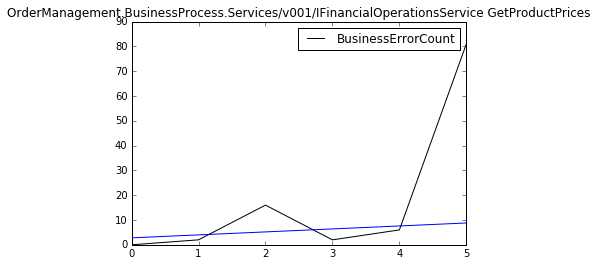

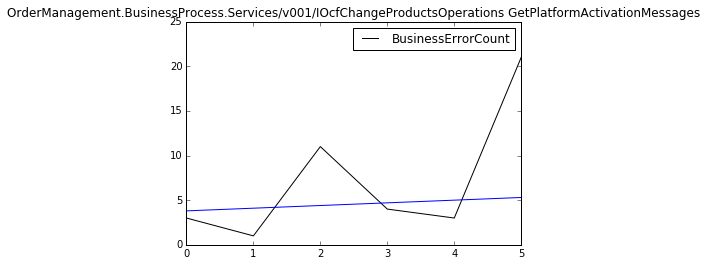

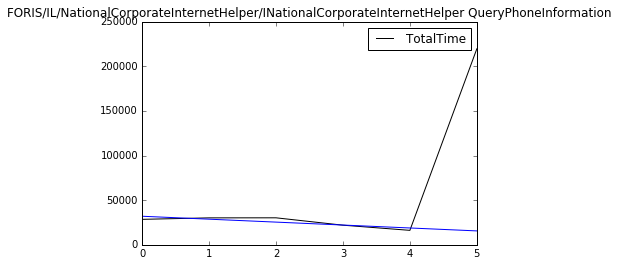

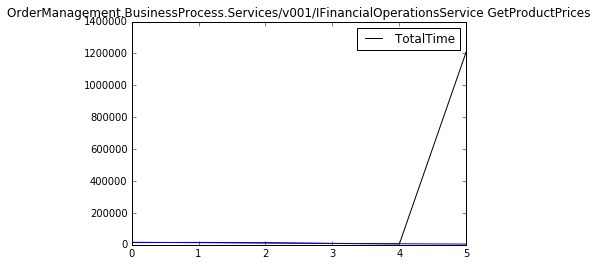

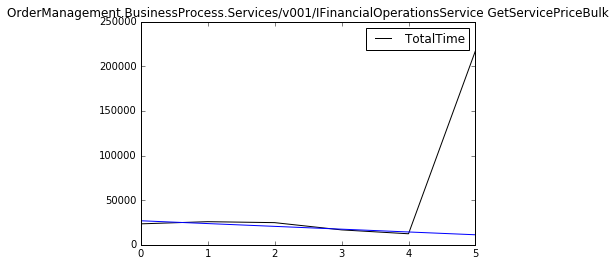

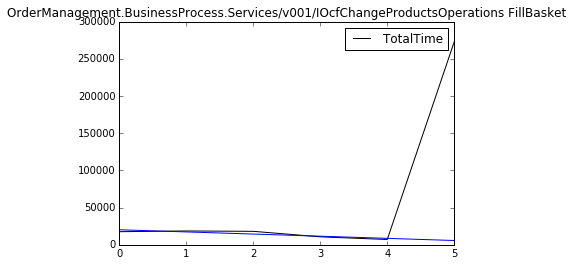

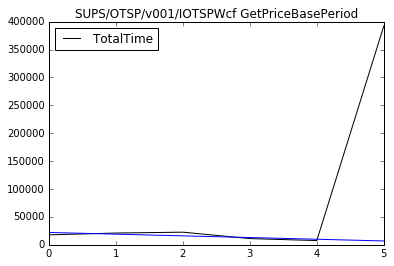

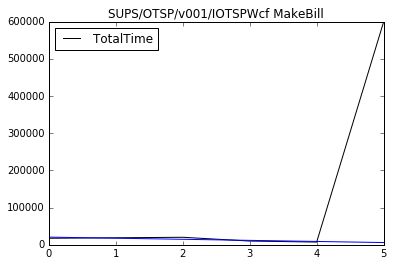

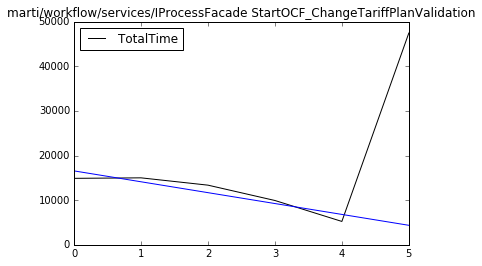

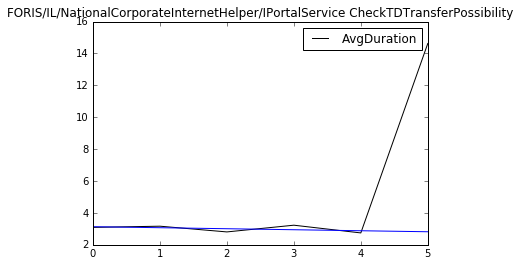

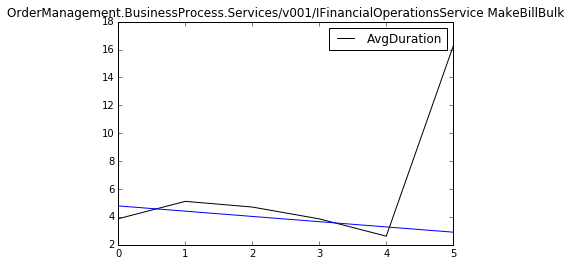

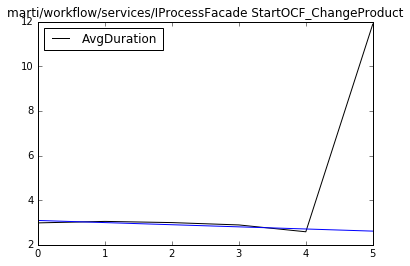

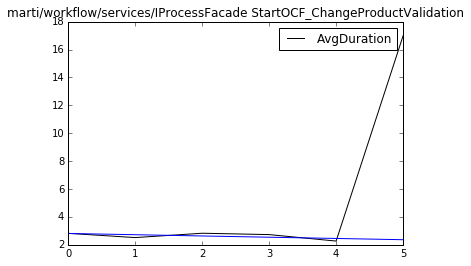

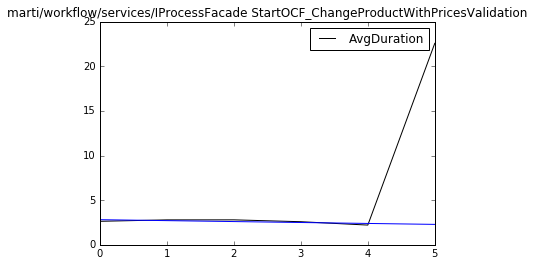

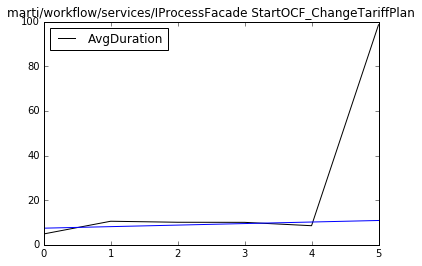

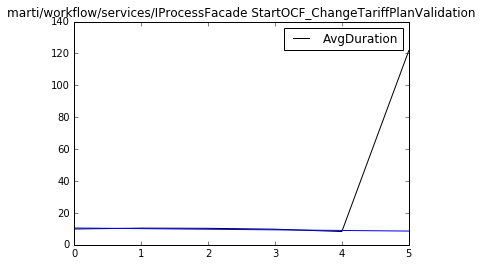

In [142]:
now='2017-09-15 00:00:00'
result = getMethodLevelAnomalies(data,now)

In [143]:
df = pd.DataFrame(result)
df.head(10)

,AnomalyStrength,INTERVAL_START,Level,Measure,object
0,9.204545,2017-09-15 00:00:00,Method,BusinessErrorCount,OrderManagement.BusinessProcess.Services/v001/...
1,3.962264,2017-09-15 00:00:00,Method,BusinessErrorCount,OrderManagement.BusinessProcess.Services/v001/...
2,8.639679,2017-09-15 00:00:00,Method,TotalTime,FORIS/IL/NationalCorporateInternetHelper/INati...
3,108.645560,2017-09-15 00:00:00,Method,TotalTime,OrderManagement.BusinessProcess.Services/v001/...
4,10.529246,2017-09-15 00:00:00,Method,TotalTime,OrderManagement.BusinessProcess.Services/v001/...
5,18.910492,2017-09-15 00:00:00,Method,TotalTime,OrderManagement.BusinessProcess.Services/v001/...
6,24.416972,2017-09-15 00:00:00,Method,TotalTime,SUPS/OTSP/v001/IOTSPWcf GetPriceBasePeriod
7,40.447859,2017-09-15 00:00:00,Method,TotalTime,SUPS/OTSP/v001/IOTSPWcf MakeBill
8,4.060741,2017-09-15 00:00:00,Method,TotalTime,marti/workflow/services/IProcessFacade StartOC...
9,4.861559,2017-09-15 00:00:00,Method,AvgDuration,FORIS/IL/NationalCorporateInternetHelper/IPort...


In [144]:
#without debug output, could be run on realtime
def getMethodLevelAnomalies(data, time, WindowSize=5, AnomalyThreshold=3.5,BusinessErrorCountThreshold=4,TotalTimeThreshold=10000,AvgDurationThreshold=2):
    report_structure = []

    data_filtered = data[(data['INTERVAL_START'] >= datetime.datetime.strptime(time, "%Y-%m-%d %H:%M:00") - datetime.timedelta(hours=WindowSize)) 
                             & (data['INTERVAL_START'] <= time)]
    data_grouped = data_filtered.groupby('ServiceContractMethod')
    for name, method_group in data_grouped:
        time_method_group = method_group.groupby('INTERVAL_START')

        #BusinessErrorCount measure
        time_method_group_measure = time_method_group.agg({'BusinessErrorCount' : np.sum})
        time_method_group_measure = time_method_group_measure.reset_index()
        if(time_method_group_measure.size > (WindowSize*2) ):
            regression_model = linear_model.LinearRegression()
            regression_model.fit(X = pd.DataFrame(time_method_group_measure.index[:-1]),y = time_method_group_measure["BusinessErrorCount"][:-1])
            train_prediction = regression_model.predict(X = pd.DataFrame(time_method_group_measure.index))
            regression_prediction = train_prediction[-1]
            mean_prediction = time_method_group_measure["BusinessErrorCount"][:-1].mean()
            if(mean_prediction<BusinessErrorCountThreshold):
                continue
            prediction = max(regression_prediction,mean_prediction)
            AnomalyStrength = list(time_method_group_measure['BusinessErrorCount'])[-1]/prediction
            if(AnomalyStrength>20):
                AnomalyStrength=20
            if(AnomalyStrength<0): 
                AnomalyStrength=0
            if(AnomalyStrength>AnomalyThreshold):
                report_structure.append({'INTERVAL_START':time,'Level':'Method','object':name,'Measure':'BusinessErrorCount','AnomalyStrength':AnomalyStrength})

    data_filtered = data[(data['INTERVAL_START'] >= datetime.datetime.strptime(time, "%Y-%m-%d %H:%M:00") - datetime.timedelta(hours=WindowSize)) 
                             & (data['INTERVAL_START'] <= time)]
    data_grouped = data_filtered.groupby('ServiceContractMethod')
    for name, method_group in data_grouped:
        time_method_group = method_group.groupby('INTERVAL_START')

        #TotalTime measure
        time_method_group_measure = time_method_group.agg({'TotalTime' : np.sum})
        time_method_group_measure = time_method_group_measure.reset_index()
        if(time_method_group_measure.size > (WindowSize*2) ):
            regression_model = linear_model.LinearRegression()
            regression_model.fit(X = pd.DataFrame(time_method_group_measure.index[:-1]),y = time_method_group_measure["TotalTime"][:-1])
            train_prediction = regression_model.predict(X = pd.DataFrame(time_method_group_measure.index))
            regression_prediction = train_prediction[-1]
            mean_prediction = time_method_group_measure["TotalTime"][:-1].mean()
            if(mean_prediction<TotalTimeThreshold):
                continue
            prediction = max(regression_prediction,mean_prediction)
            AnomalyStrength = list(time_method_group_measure['TotalTime'])[-1]/prediction
            if(AnomalyStrength>30):
                AnomalyStrength=30
            if(AnomalyStrength<0): 
                AnomalyStrength=0
            if(AnomalyStrength>AnomalyThreshold):
                report_structure.append({'INTERVAL_START':time,'Level':'Method','object':name,'Measure':'TotalTime','AnomalyStrength':AnomalyStrength})

    data_filtered = data[(data['INTERVAL_START'] >= datetime.datetime.strptime(time, "%Y-%m-%d %H:%M:00") - datetime.timedelta(hours=WindowSize)) 
                             & (data['INTERVAL_START'] <= time)]
    data_grouped = data_filtered.groupby('ServiceContractMethod')
    for name, method_group in data_grouped:
        time_method_group = method_group.groupby('INTERVAL_START')

        #AvgDuration measure
        time_method_group_measure = time_method_group.agg({'AvgDuration' : np.mean})
        time_method_group_measure = time_method_group_measure.reset_index()
        if(time_method_group_measure.size > (WindowSize*2) ):

            regression_model = linear_model.LinearRegression()
            regression_model.fit(X = pd.DataFrame(time_method_group_measure.index[:-1]),y = time_method_group_measure["AvgDuration"][:-1])
            train_prediction = regression_model.predict(X = pd.DataFrame(time_method_group_measure.index))
            regression_prediction = train_prediction[-1]
            mean_prediction = time_method_group_measure["AvgDuration"][:-1].mean()
            if(mean_prediction<AvgDurationThreshold):
                continue
            prediction = max(regression_prediction,mean_prediction)
            AnomalyStrength = list(time_method_group_measure['AvgDuration'])[-1]/prediction
            if(AnomalyStrength>30):
                AnomalyStrength=30
            if(AnomalyStrength<0): 
                AnomalyStrength=0
            if(AnomalyStrength>AnomalyThreshold):
                report_structure.append({'INTERVAL_START':time,'Level':'Method','object':name,'Measure':'AvgDuration','AnomalyStrength':AnomalyStrength})
    
    return report_structure

In [145]:
now='2017-09-15 00:00:00'
result = getMethodLevelAnomalies(data,now)

In [146]:
df = pd.DataFrame(result)
df.head(10)

,AnomalyStrength,INTERVAL_START,Level,Measure,object
0,9.204545,2017-09-15 00:00:00,Method,BusinessErrorCount,OrderManagement.BusinessProcess.Services/v001/...
1,3.962264,2017-09-15 00:00:00,Method,BusinessErrorCount,OrderManagement.BusinessProcess.Services/v001/...
2,8.639679,2017-09-15 00:00:00,Method,TotalTime,FORIS/IL/NationalCorporateInternetHelper/INati...
3,30.000000,2017-09-15 00:00:00,Method,TotalTime,OrderManagement.BusinessProcess.Services/v001/...
4,10.529246,2017-09-15 00:00:00,Method,TotalTime,OrderManagement.BusinessProcess.Services/v001/...
5,18.910492,2017-09-15 00:00:00,Method,TotalTime,OrderManagement.BusinessProcess.Services/v001/...
6,24.416972,2017-09-15 00:00:00,Method,TotalTime,SUPS/OTSP/v001/IOTSPWcf GetPriceBasePeriod
7,30.000000,2017-09-15 00:00:00,Method,TotalTime,SUPS/OTSP/v001/IOTSPWcf MakeBill
8,4.060741,2017-09-15 00:00:00,Method,TotalTime,marti/workflow/services/IProcessFacade StartOC...
9,4.861559,2017-09-15 00:00:00,Method,AvgDuration,FORIS/IL/NationalCorporateInternetHelper/IPort...


In [147]:
def perdelta(start, end, delta):
    curr = start
    while curr <= end:
        yield curr
        curr += delta
        
def generateDateRangeByHour(fromt,tot):
    result = []
    for dt in perdelta(datetime.datetime.strptime(fromt, "%Y-%m-%d %H:%M:00"),
                       datetime.datetime.strptime(tot, "%Y-%m-%d %H:%M:00"),
                       timedelta(hours=1)):
        result.append(str(dt))
    return result


print(generateDateRangeByHour('2017-09-14 00:00:00','2017-09-14 12:00:00'))

['2017-09-14 00:00:00', '2017-09-14 01:00:00', '2017-09-14 02:00:00', '2017-09-14 03:00:00', '2017-09-14 04:00:00', '2017-09-14 05:00:00', '2017-09-14 06:00:00', '2017-09-14 07:00:00', '2017-09-14 08:00:00', '2017-09-14 09:00:00', '2017-09-14 10:00:00', '2017-09-14 11:00:00', '2017-09-14 12:00:00']


In [148]:
#batch data processing. Could take a lot of time, for me 10 minutes.
#complexity: methodCount * hoursCount
def analysePeriod(data,fromt,tot):
    result = []
    times = generateDateRangeByHour(fromt,tot)
    for now in times:
        result = result + getMethodLevelAnomalies(data,now)
    return result

In [149]:
result = analysePeriod(data,'2017-09-14 06:00:00','2017-09-16 00:00:00') #move to 16 00:00


In [150]:
df = pd.DataFrame(result)
df = df.set_index('INTERVAL_START')
df.head(50)

,AnomalyStrength,Level,Measure,object
INTERVAL_START,,,,
2017-09-14 06:00:00,3.537736,Method,BusinessErrorCount,Foris.OrderManagement.Workflow2.Services/v001/...
2017-09-14 07:00:00,3.736842,Method,BusinessErrorCount,marti/workflow/services/IProcessFacade StartOC...
2017-09-14 08:00:00,3.863636,Method,BusinessErrorCount,OrderManagement.BusinessProcess.Services/v001/...
2017-09-14 08:00:00,8.750000,Method,BusinessErrorCount,marti/workflow/services/IProcessFacade StartCh...
2017-09-14 08:00:00,7.086245,Method,AvgDuration,marti/sales/services/IRequestDirectory Workflo...
2017-09-14 09:00:00,4.262295,Method,BusinessErrorCount,OrderManagement.BusinessProcess.Services/v001/...
2017-09-14 09:00:00,20.000000,Method,BusinessErrorCount,marti/workflow/services/IProcessFacade StartOC...
2017-09-14 09:00:00,3.782584,Method,AvgDuration,OrderManagement.BusinessProcess.Services/v001/...
2017-09-14 10:00:00,4.485940,Method,AvgDuration,billing/AccountsReceivable/IFinancialData GetH...


In [151]:
writer = pd.ExcelWriter('output.xlsx')
df.to_excel(writer,'Sheet1')
writer.save()

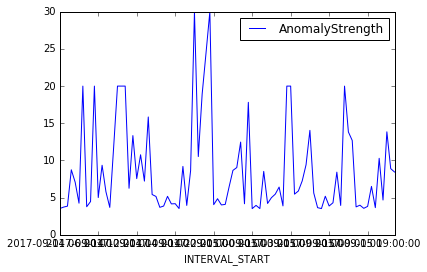

In [152]:
df.plot()

In [156]:
import plotly 
import plotly.plotly as py
import plotly.graph_objs as go

plotly.tools.set_credentials_file(username='aydar.tech', api_key='Ify4HOzEdTSWSXOnm7wX')

layout= go.Layout(
    title= 'SystemAnomalyAnalysis',
    hovermode= 'closest',
    xaxis= dict(
        title= 'DateTime',
        zeroline= False,
    ),
    yaxis=dict(
        title= 'AnomalyStrength',
    )
)

group=df.groupby('Measure').get_group('AvgDuration')
AvgDurationAnomaly = go.Scatter(
    x = group.index,
    text= group['object'],
    y = group['AnomalyStrength'],
    name = 'AvgDurationAnomaly',
    mode = 'markers',
)
group=df.groupby('Measure').get_group('BusinessErrorCount')
BusinessErrorCountAnomaly = go.Scatter(
    x = group.index,
    text= group['object'],
    y = group['AnomalyStrength'],
    name = 'BusinessErrorCountAnomaly',
    mode = 'markers',
)
group=df.groupby('Measure').get_group('TotalTime')
TotalTimeAnomaly = go.Scatter(
    x = group.index,
    text= group['object'],
    y = group['AnomalyStrength'],
    name = 'TotalTimeAnomaly',
    mode = 'markers',
)

data = [AvgDurationAnomaly,BusinessErrorCountAnomaly,TotalTimeAnomaly]

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='SystemAnomalyAnalysis')